#2. nD 2Class Continuous - Iris Dataset

In [52]:
from pylab import *
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from __future__ import division
t=np.seterr(divide='ignore', invalid='ignore')

### Preparing the Input Dataset ready

In [173]:
def getData(fileName):
    if fileName == 'Breast-Cancer':
        with open('breast-cancer-wisconsin.data','r') as f:
            records=[]
            for line in f:
                records.append(line.split(','))
        records = records[2:]
        dataset = np.array(records).astype(np.int)
    elif fileName == 'Iris':
        classCount = 2 #Only two classes required
        from sklearn import datasets
        data = datasets.load_iris() 
        #data = datasets.load_boston() 
        #data = datasets.load_diabetes()
        X = data['data']
        Y = data['target']
        Y = Y.reshape(len(data['target']), 1)
        dataset = np.hstack((X, Y))
    
        idx_k=[]
        if classCount == 2:
            (m, n) = dataset.shape
            class_k = np.unique(dataset[:,n-1])
            k = len(class_k)
            for i in range(classCount):
                idx_k.append(filter((lambda x : dataset[:,n-1][x] == class_k[i]), range(m)))
            idx_k = np.concatenate((idx_k[0], idx_k[1]), axis=0)
            dataset = dataset[idx_k]
    
    return dataset

###Computing the Confusion Matrix

In [54]:
def getConfusionMatrix(actual, prediction, class_k):
    k = len(class_k)
    m = len(actual)
    cm = np.zeros((k, k))
    for i in range(k):
        actual_i = filter(lambda x: actual[x] == class_k[i], range(m))
        for j in range(k):
            predicted_j = filter(lambda x: prediction[x] == class_k[j], range(m))
            cm[i,j] = len(np.intersect1d(actual_i, predicted_j))
    return cm 

###Calculating the Performance Metrics

In [55]:
def getAccuracy(matrix):
    return np.trace(matrix)/np.sum(matrix)

def getPrecision(matrix):
    k = len(matrix)
    precision = np.zeros(k)
    for i in range(k):
        actual_positives = np.sum(matrix[i])
        precision[i] = matrix[i,i]/actual_positives
    return precision

def getRecall(matrix):
    k = len(matrix)
    recall = np.zeros(k)
    for i in range(k):
        predicted_positives = np.sum(matrix[:,i])
        recall[i] = matrix[i,i]/predicted_positives
    return recall

def getFMeasure(precision, recall):
    k = len(precision)
    fm = np.zeros(k)
    for i in range(k):
        fm[i] = 2* precision[i]*recall[i]/(precision[i]+recall[i])
    return fm

###Classifying based on the Membership Function

In [56]:
def classify(g, class_k):
    (m, n) = g.shape
    estimate = np.zeros((m,1))
    
    for i in range(m):
            estimate[i] = class_k[np.argmax(g[i])]
            
    return estimate

###Computing the Membership Function

In [57]:
def computeMembership(X, modelParam):
    (m, n) = X.shape
    mean_k = modelParam['mean']
    covariance_k = modelParam['sigma']
    alpha_k = modelParam['alpha']
    m_k = modelParam['m']
    k = len(m_k)
    
    g = np.zeros((m,k))
    for j in range(k):
        if m_k[j] is not 0:
            det_sigma_k = np.linalg.det(covariance_k[j])
            sigma_inv = np.linalg.inv(covariance_k[j])
            for i in range(m):
                X_mu = X[i] - mean_k[j]
                g[i,j] = -np.log(det_sigma_k) + np.log(alpha_k[j]) - np.dot(np.dot(X_mu, sigma_inv), X_mu.T)
        else:
            g[:,j] = -inf * np.ones(m)
            
    return g

###Training the Classifier and Testing the Performance

In [116]:
def train(data, train_idx, test_idx, class_k, mode, threshold):
    (m, n) = data.shape
    k = len(class_k)
    training_data = data[train_idx]
    m_train = len(training_data)
    X_train = training_data[:,:n-1].reshape((m_train,n-1))
    Y_train = training_data[:,n-1].reshape((m_train,1))
    
    
    #Distribution Model = Gaussian
    mean_k = {}
    covariance_k = {}
    m_train_k = {}
    X_train_k = {}
    train_idx_k = {}
    alpha_k = {}
    
    #Determining Model Parameters
    for i in range(k):
        train_idx_k[i] = filter((lambda x : data[:,n-1][x] == class_k[i]), train_idx)
        X_train_k[i] = data[:, :n-1][train_idx_k[i]]
        m_train_k[i] = len(X_train_k[i])
        alpha_k[i] = m_train_k[i]/m_train
        if m_train_k[i] is not 0:
            mean_k[i] = np.mean(X_train_k[i],axis=0)
            X_mu_k = X_train_k[i]-mean_k[i]
            covariance_k[i] = np.dot(X_mu_k.T,(X_mu_k))/m_train_k[i]
    
    #Consolidating Model Parameters
    modelParam = {}
    modelParam['mean'] = mean_k
    modelParam['sigma'] = covariance_k
    modelParam['alpha'] = alpha_k
    modelParam['m'] = m_train_k
    result = {}
    
    #Compute Membership Function
    g_train = computeMembership(X_train, modelParam)
    
    #Classification
    if mode == 0: #For Classification
        Y_train_hat = classify(g_train, class_k)
    if mode == 1: #For PR Curve
        Y_train_hat = np.zeros((m_train,1))
        d = g_train[:,0] - g_train[:,1]
        for i in range(m_train):
            if d[i] > threshold:
                Y_train_hat[i] = class_k[0]
            else:
                Y_train_hat[i] = class_k[1]
    
    #For Debug Purpose: Computing Training Error
    '''
    confMatrix = getConfusionMatrix(Y_train, Y_train_hat, class_k)    
    precision = getPrecision(confMatrix)
    accuracy = getAccuracy(confMatrix)
    recall = getRecall(confMatrix)
    FMeasure = getFMeasure(precision, recall)
    result['ConfusionMatrix'] = confMatrix
    result['precision'] = precision
    result['accuracy'] = accuracy
    result['recall'] = recall
    result['FMeasure'] = FMeasure
    '''
    #Testing
    test_data = data[test_idx]
    m_test = len(test_data)
    X_test = test_data[:,:n-1].reshape((m_test,n-1))
    Y_test = test_data[:,n-1].reshape((m_test,1))
    result = {}
    
    #Compute Membership Function
    g_test = computeMembership(X_test, modelParam)

    #Classification
    if mode == 0:
        Y_test_hat = classify(g_test, class_k)
        result['d'] = g_test[:,0] - g_test[:,1]
    if mode == 1:
        Y_test_hat = np.zeros((m_test,1))
        d = g_test[:,0] - g_test[:,1]
        for i in range(m_test):
            if d[i] > threshold:
                Y_test_hat[i] = class_k[0]
            else:
                Y_test_hat[i] = class_k[1]

    
    confMatrix = getConfusionMatrix(Y_test, Y_test_hat, class_k)    
    precision = getPrecision(confMatrix)
    accuracy = getAccuracy(confMatrix)
    recall = getRecall(confMatrix)
    FMeasure = getFMeasure(precision, recall)

    #Consolidating the results
    result['ConfusionMatrix'] = confMatrix
    result['precision'] = precision
    result['accuracy'] = accuracy
    result['recall'] = recall
    result['FMeasure'] = FMeasure
    
    return result

###For Debug purpose only: To view the PR Curve for the entire dataset

In [185]:
def plotPRCurve(data, class_k):
    (m, n) = data.shape
    k = len(class_k)
    #print "m, n, k", m, n, k
    X_train = data[:,:n-1].reshape((m,n-1))
    Y_train = data[:,n-1].reshape((m,1))
    
    #Distribution Model = Gaussian
    mean_k = {}
    covariance_k = {}
    m_train_k = {}
    X_train_k = {}
    idx_k = {}
    alpha_k = {}
    
    #Determining Model Parameters
    for i in range(k):
        idx_k[i] = filter((lambda x : data[:,n-1][x] == class_k[i]), range(m))
        X_train_k[i] = data[:, :n-1][idx_k[i]]
        m_train_k[i] = len(X_train_k[i])
        alpha_k[i] = m_train_k[i]/m
        if m_train_k[i] is not 0:
            mean_k[i] = np.mean(X_train_k[i],axis=0)
            X_mu_k = X_train_k[i]-mean_k[i]
            covariance_k[i] = np.dot(X_mu_k.T,(X_mu_k))/m_train_k[i]    
    
    modelParam = {}
    modelParam['mean'] = mean_k
    modelParam['sigma'] = covariance_k
    modelParam['alpha'] = alpha_k
    modelParam['m'] = m_train_k
    
    #Compute Membership Function
    g_train = computeMembership(X_train, modelParam)
    
    #Classification
    Y_train_hat = np.zeros((m,1))
    
    d = g_train[:,0] - g_train[:,1]
    start_d = int(round(np.amin(d)))
    stop_d = int(round(np.amax(d)))
    #print start_d, stop_d
    
    precision = np.empty((1,k))
    recall = np.empty((1,k))

    for j in range(start_d-50, stop_d+50, 10):
        for i in range(m):
            if d[i] > j:
                Y_train_hat[i] = class_k[0]
            else:
                Y_train_hat[i] = class_k[1]
        confMatrix = getConfusionMatrix(Y_train, Y_train_hat, class_k)    
        #print "Confusion Matrix"
        #print confMatrix
        p = getPrecision(confMatrix)
        #print "Precision", p[0]
        r = getRecall(confMatrix)
        #print "Recall", r[0]
        precision = np.vstack((precision, p))
        recall = np.vstack((recall, r))

    precision = precision[1:,:]
    recall = recall[1:,:]
    #print np.trapz(precision[:,0], dx=0.01, axis=0)
    
    from sklearn import metrics
    from sklearn.metrics import precision_recall_curve
    print metrics.auc(precision[:,0], recall[:,0])
    
    #Plotting Curve
    fig=plt.figure(figsize=(15,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('PR Curve')
    ax.set_xlim(min(recall[:,0]), 1.1)
    ax.set_ylim(0, 1.5)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.plot(recall[:,0], precision[:,0], 'ro')
    
    return 

###Main function to perform the experiment

Confusion Matrix
[[ 415.   27.]
 [   6.  233.]]
Accuracy	:	0.951598465473
Precision	:	0.931508464593
Recall		:	0.981138376519
F-Measure	:	0.955679514921
AUC		:	0.740587094816


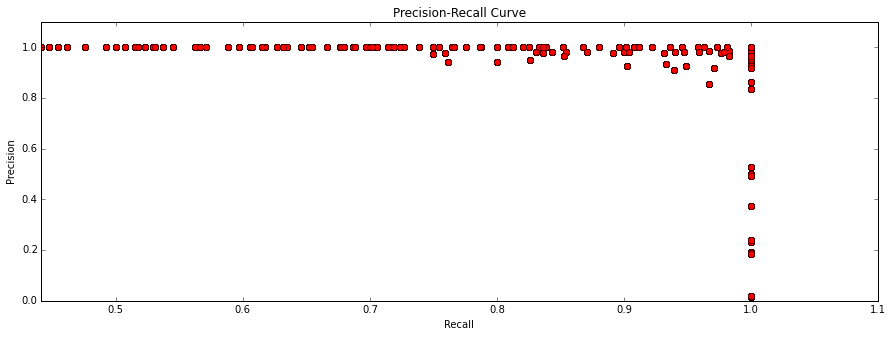

In [195]:
def run(fileName, K):
    dataset = getData(fileName)
    #dataset = getData1()
    (rows, cols) = dataset.shape
    class_k = np.unique(dataset[:,cols-1])
    k = len(class_k)
    #print "class", class_k
    
    CV_idx = KFold(len(dataset), n_folds=K)
    i = 0
    result = []
    
    #Gaussian Discriminant Analysis
    mode = 0 #Experiment
    threshold = 0
    
    for train_idx, test_idx in CV_idx:
        #print len(train_idx), len(test_idx)
        result.append(train(dataset, train_idx, test_idx, class_k, mode, threshold))
        i+=1
    
    conf_mat = np.zeros((k, k))
    precision = np.empty((1,k))
    recall = np.empty((1,k))
    d = np.empty((1,2))
    accuracy=0
    
    for j in range(i):
        conf_mat = np.add(conf_mat, result[j]['ConfusionMatrix'])
        precision = np.vstack((precision, result[j]['precision']))
        recall = np.vstack((recall, result[j]['recall']))
        accuracy += result[j]['accuracy']
        d = np.vstack((d, [np.amin(result[j]['d']), np.amax(result[j]['d'])]))
    d = d[1:,:]
    start_d = int(round(np.amin(d[:,0])))
    stop_d = int(round(np.amax(d[:,1])))
    
    precision = np.nanmean(precision[1:,:], axis=0)
    recall = np.nanmean(recall[1:,:], axis=0)
    fMeasure = getFMeasure(precision, recall)
    accuracy/=K
    
    print "Confusion Matrix"
    print conf_mat
    print "Accuracy\t:\t", accuracy
    print "Precision\t:\t", precision[0]
    print "Recall\t\t:\t", recall[0]
    print "F-Measure\t:\t", fMeasure[0]
    
    #For Debug Pupose Only
    '''
    if cols-1 > 1 and k == 2:
        plotPRCurve(dataset, class_k)
    '''
    
    #Plotting Precision-Recall Curve
    mode = 1 #PR-Curve Varying Threshold
    i = 0
    result = []

    precision = np.empty((1,k))
    recall = np.empty((1,k))
    for threshold in range(start_d, stop_d, 25):
        for train_idx, test_idx in CV_idx:
            result.append(train(dataset, train_idx, test_idx, class_k, mode, threshold))
            i+=1
    
        p = np.empty((1,k))
        r = np.empty((1,k))
    
        for j in range(i):
            precision = np.vstack((precision, result[j]['precision']))
            recall = np.vstack((recall, result[j]['recall']))
    
        p = np.nanmean(p[1:,:], axis=0)
        r = np.nanmean(r[1:,:], axis=0)
        precision = np.vstack((precision, p))
        recall = np.vstack((recall, r))
        
    precision = precision[1:,:]
    recall = recall[1:,:]    
    tmp = precision[:,0]
    tmp = tmp[~np.isnan(tmp)]
    print "AUC\t\t:\t", np.nanmean(tmp)
    
    fig=plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Precision-Recall Curve')
    ax.set_xlim(min(recall[:,0]), 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.plot(recall[:,0], precision[:,0], 'ro')
    #ax.plot(recall[:,1], precision[:,1], 'bs')
    ax.scatter(recall[:,0], precision[:,0], marker='o')
    
    #'''
    
if __name__ == '__main__':
    #fileName='Iris'
    fileName='Breast-Cancer'
    run(fileName,10)